<a href="https://colab.research.google.com/github/SourLemon23/Eye-Net/blob/main/Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

! pip install tensorflow-addons
import tensorflow_addons as tfa
# causes errors
# from tensorflow_addons.metrics import F1Score
from tensorflow_addons.metrics import CohenKappa

import tensorflow.keras.backend as K
from tensorflow import GradientTape

from tensorflow.image import resize
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

import seaborn as sns
from sklearn.manifold import TSNE
!pip install shap
import shap
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ! pip install -U efficientnet
# from efficientnet.tfkeras import EfficientNetB4

Using TensorFlow Version: 2.5.0
     |████████████████████████████████| 679 kB 8.1 MB/s 
     |████████████████████████████████| 356 kB 8.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491637 sha256=7e562babaaf643302a9196a2f0773b5d76be042f8755d793719b822009554975
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Tensorboard logs - Justin's path
# logs = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/TB_logs'

In [ ]:
# # Folder to save all models - specify your model name at the end of filepath
# model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/EfficientNet-B4'

In [ ]:
dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/cropped_APTOS_dataset'
labels = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/v2APTOSBinaryData.csv'

In [ ]:
CLASSES = ['0 - No DR', '1 - DR']

CHANNELS = 3
COLOR_MODE = 'rgb'

IMG_WIDTH, IMG_HEIGHT = 250, 250
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

LEARNING_RATE = 0.001 # default for Adam
MIN_DELTA = 1e-5
PATIENCE = 4
BATCH_SIZE = 32
EPOCHS = 5
# EPOCHS = 1
VALIDATION_SPLIT = 0.15
PERCENTAGE_FACTOR = 100;
THRESHOLD_VALUE = 0.5

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall'),
          #  F1Score(num_classes=2),
           CohenKappa(num_classes=2)]

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

In [ ]:
train_data = pd.read_csv(labels, dtype = str)
Y = train_data['diagnosis']

In [ ]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['Presence of DR','# Samples']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'Presence of DR', y='# Samples', data = df_group, palette = "Blues_d")
    plt.title('Class Distribution')
    plt.show()

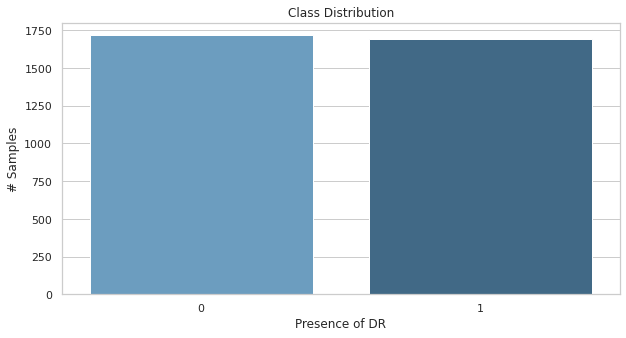

In [ ]:
plot_classes(train_data)

In [ ]:
# data_gen = ImageDataGenerator(rescale=1./255,
#                               validation_split=VALIDATION_SPLIT)

# img_generator = data_gen.flow_from_dataframe(train_data,
#                                             directory = dataset_dir,
#                                             subset = "validation",
#                                             x_col = "id_code", y_col = "diagnosis",
#                                             color_mode=COLOR_MODE,
#                                             target_size=TARGET_SIZE,
#                                             class_mode='binary',
#                                             batch_size=BATCH_SIZE,
#                                             interpolation="bicubic",
#                                             shuffle=False,
#                                             validate_filenames=True)

In [ ]:
# batch = img_generator.next()
# image_batch = batch[0]
# batch_labels = batch[1]

In [ ]:
def grayscale(gen_image):
    grayscale_img = cv2.cvtColor(gen_image, cv2.COLOR_BGR2GRAY)
    grayscale_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2BGR)

    return grayscale_img

In [ ]:
def hsv(gen_image):
    hsv_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2HSV)

    clahe_filter = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv_img = clahe_filter.apply(hsv_img[:, :, 2].astype(np.uint8))
    hsv_img = cv2.cvtColor(hsv_img, cv2.COLOR_GRAY2BGR) / 255

    return hsv_img

In [ ]:
def ycrcb(gen_image):
    ycrcb_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2YCrCb)
    
    clahe_filter = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    ycrcb_img = clahe_filter.apply(ycrcb_img[:, :, 1].astype(np.uint8))
    ycrcb_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_GRAY2BGR) / 255

    return ycrcb_img

In [ ]:
def lab(gen_image):
    lab_img = cv2.cvtColor(gen_image, cv2.COLOR_BGR2LAB)

    clahe_filter = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_img = clahe_filter.apply(lab_img[:, :, 0].astype(np.uint8))
    lab_img = cv2.cvtColor(lab_img, cv2.COLOR_GRAY2BGR) / 255

    return lab_img

In [ ]:
def gaussian_blur(gen_image):
    g_blurred_img = cv2.GaussianBlur(gen_image, (5, 5), 0)

    # some sample code to duplicate grayscale across 3 channels to be compatible with models
    # cv2.COLOR_GRAY2BGR does the same
    # print(np.repeat(g_blurred_img[:, :, np.newaxis], repeats=3, axis=2).shape)
    # g_blurred_img = np.repeat(g_blurred_img[:, :, np.newaxis], repeats=3, axis=2)
    # g_blurred_img = cv2.cvtColor(g_blurred_img, cv2.COLOR_GRAY2BGR)
    # print(g_blurred_img.shape)

    # img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
    # img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
    # img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    # # print(img1.shape,img2.shape,img3.shape)
    # img = np.stack([img1,img2,img3],axis=-1)


    return g_blurred_img

In [ ]:
def gaussian_blur_enhance(gen_image):
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY)
    g_blurred_img_enhanced = cv2.addWeighted(grayscale_img, 4, cv2.GaussianBlur(grayscale_img, (0, 0), 50), -4, 128)
    g_blurred_img_enhanced = cv2.cvtColor(g_blurred_img_enhanced / 255, cv2.COLOR_GRAY2BGR)
    return g_blurred_img_enhanced

In [ ]:
def median_blur(gen_image):
    med_blurred_img = cv2.medianBlur(gen_image, 5)
    return med_blurred_img

In [ ]:
def bilateral(gen_image):
    bilat_filtered_img = cv2.bilateralFilter(gen_image, 9, 75, 75)
    return bilat_filtered_img

In [ ]:
def bilateral_vessel(gen_image):
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY)

    bilat_filtered_img = cv2.addWeighted(grayscale_img, 4, cv2.bilateralFilter(grayscale_img, 9, 75, 75), -4, 128)
    bilat_filtered_img = cv2.cvtColor(bilat_filtered_img / 255, cv2.COLOR_GRAY2BGR)

    return bilat_filtered_img

In [ ]:
def canny_edge_detection(gen_image):
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY)

    computed_edges = cv2.Canny(grayscale_img.astype(np.uint8), 20, 90, True)
    # this line makes the output black and white
    computed_edges = cv2.cvtColor(computed_edges, cv2.COLOR_GRAY2BGR) / 255

    return computed_edges

In [ ]:
def erode(gen_image):
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((8, 8), dtype=np.uint8)
    eroded_img = cv2.erode(grayscale_img, kernel, iterations=1)
    eroded_img = cv2.cvtColor(eroded_img, cv2.COLOR_GRAY2BGR) / 255

    return eroded_img

In [ ]:
def dilate(gen_image):    
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((8, 8), dtype=np.uint8)
    dilated_img = cv2.dilate(grayscale_img, kernel, iterations=1)
    dilated_img = cv2.cvtColor(dilated_img, cv2.COLOR_GRAY2BGR) / 255

    return dilated_img

In [ ]:
def equalize_hist(gen_image):    
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    equalized = cv2.equalizeHist(grayscale_img)
    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR) / 255
    return equalized

In [ ]:
def cla_equalize_hist(gen_image):
    grayscale_img = cv2.cvtColor(gen_image * 255, cv2.COLOR_BGR2GRAY).astype(np.uint8) # unit 8 or 16

    clahe_filter = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe = clahe_filter.apply(grayscale_img)
    clahe = cv2.cvtColor(clahe, cv2.COLOR_GRAY2BGR) / 255

    return clahe

In [ ]:
# cv2's StaticSaliencyFineGrained_create() did not work for fundus scans
# static doesn't work great either
def static_spectral_saliency(generator_image):
    gen_image = generator_image.copy()
    grayscale_img = cv2.cvtColor(generator_image, cv2.COLOR_BGR2GRAY)

    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    (success, saliencyMap) = saliency.computeSaliency(grayscale_img)
    saliencyMap_3d = np.repeat(saliencyMap[:, :, np.newaxis], repeats=3, axis=2)
    mask = saliencyMap_3d.copy()

    # Same: thresh_map = cv2.threshold(saliency_map.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh_map = cv2.threshold((saliencyMap * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours, hierarchy = cv2.findContours(thresh_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    body_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, (0,255,0), 3)
    cv2.drawContours(body_mask, contours, -1, 1, -1)
    body_mask = body_mask.astype(bool)
    bg_mask = (~body_mask) & (gen_image > 0)[:, :, 0]
    dark_bg_mask = bg_mask & (~thresh_map)
    bg_mean = np.mean(gen_image[dark_bg_mask])
    gen_image[bg_mask] = bg_mean

    # return gen_image, saliencyMap, mask, thresh_map
    return gen_image

In [ ]:
# generator_image = image_batch[13]
# generator_image_mask, saliencyMap_3d, mask, thresh_map = static_spectral_saliency(generator_image)

# plt.grid(True)
# plt.imshow(generator_image)
# plt.show()
# plt.grid(True)
# plt.imshow(saliencyMap_3d, cmap='gist_heat') # cmap='gray'
# plt.show()
# plt.grid(True)
# plt.imshow(mask)
# plt.show()
# plt.grid(True)
# plt.imshow(thresh_map)
# plt.show()
# plt.grid(True)
# plt.imshow(generator_image_mask)
# plt.show()

# print(generator_image_mask)

In [ ]:
def color_quantization(generator_image):
    Z = generator_image.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 24
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Make original image
    resulting_image = center[label.flatten()]
    resulting_image_reshaped = (resulting_image.reshape((generator_image.shape)) / 255) * 255
    # resulting_image_reshaped = resulting_image.reshape((generator_image.shape))
    return resulting_image_reshaped

In [ ]:
data_gen = ImageDataGenerator(validation_split=VALIDATION_SPLIT,
                              featurewise_center=True,
                              featurewise_std_normalization=True,
                              rescale=1./255,              # Simplify pixel values to be 0-1
                              horizontal_flip=True,        # Randomly flip images horizontally
                              zoom_range=0.1,              # Randomly zoom
                              shear_range=0.05,            # Shear angle in counter-clockwise direction
                              rotation_range=5,            # Randomly rotate
                              width_shift_range=0.03,      # Randomly shift the image left/right
                              height_shift_range=0.03,     # Randomly shift the image up/down
                              fill_mode='constant',        # Filling mode for points outside boundaries
                              cval=60,                     # Value used for points outside the boundaries
                              brightness_range=(0.9, 1.1), # Randomly adjust the brightness
                              preprocessing_function=static_spectral_saliency)

In [ ]:
training_generator = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
                                                    subset = "training",
                                                    x_col = "id_code", y_col = "diagnosis",
                                                    color_mode=COLOR_MODE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    interpolation="bicubic",
                                                    shuffle=True,
                                                    validate_filenames=True)

validation_generator = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
                                                    subset = "validation",
                                                    x_col = "id_code", y_col = "diagnosis",
                                                    color_mode=COLOR_MODE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    interpolation="bicubic",
                                                    shuffle=True,
                                                    validate_filenames=True)

Found 2900 validated image filenames belonging to 2 classes.
Found 511 validated image filenames belonging to 2 classes.


In [ ]:
# data_gen = ImageDataGenerator(rescale=1./255,
#                               validation_split=VALIDATION_SPLIT,
#                               preprocessing_function=cla_equalize_hist)

# img_generator = data_gen.flow_from_dataframe(train_data,
#                                             directory = dataset_dir,
#                                             subset = "validation",
#                                             x_col = "id_code", y_col = "diagnosis",
#                                             color_mode=COLOR_MODE,
#                                             target_size=TARGET_SIZE,
#                                             class_mode='binary',
#                                             batch_size=BATCH_SIZE,
#                                             interpolation="bicubic",
#                                             shuffle=False,
#                                             validate_filenames=True)

# batch = img_generator.next()
# image_batch = batch[0]
# batch_labels = batch[1]

In [ ]:
def visualize_augmentations(data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        if int(batch_labels[i]) == 0:
            title = 'no_DR'
            font_settings.update({'color': 'blue'})
        else:
            title = 'DR'
            font_settings.update({'color': 'red'})

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=font_settings)
            axs[0, i].axis('off')
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=font_settings)
            axs[1, i - 8].axis('off')
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=font_settings)
            axs[2, i - 16].axis('off')
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=font_settings)     
            axs[3, i - 24].axis('off')   

    plt.show()

Training Batch:


This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.


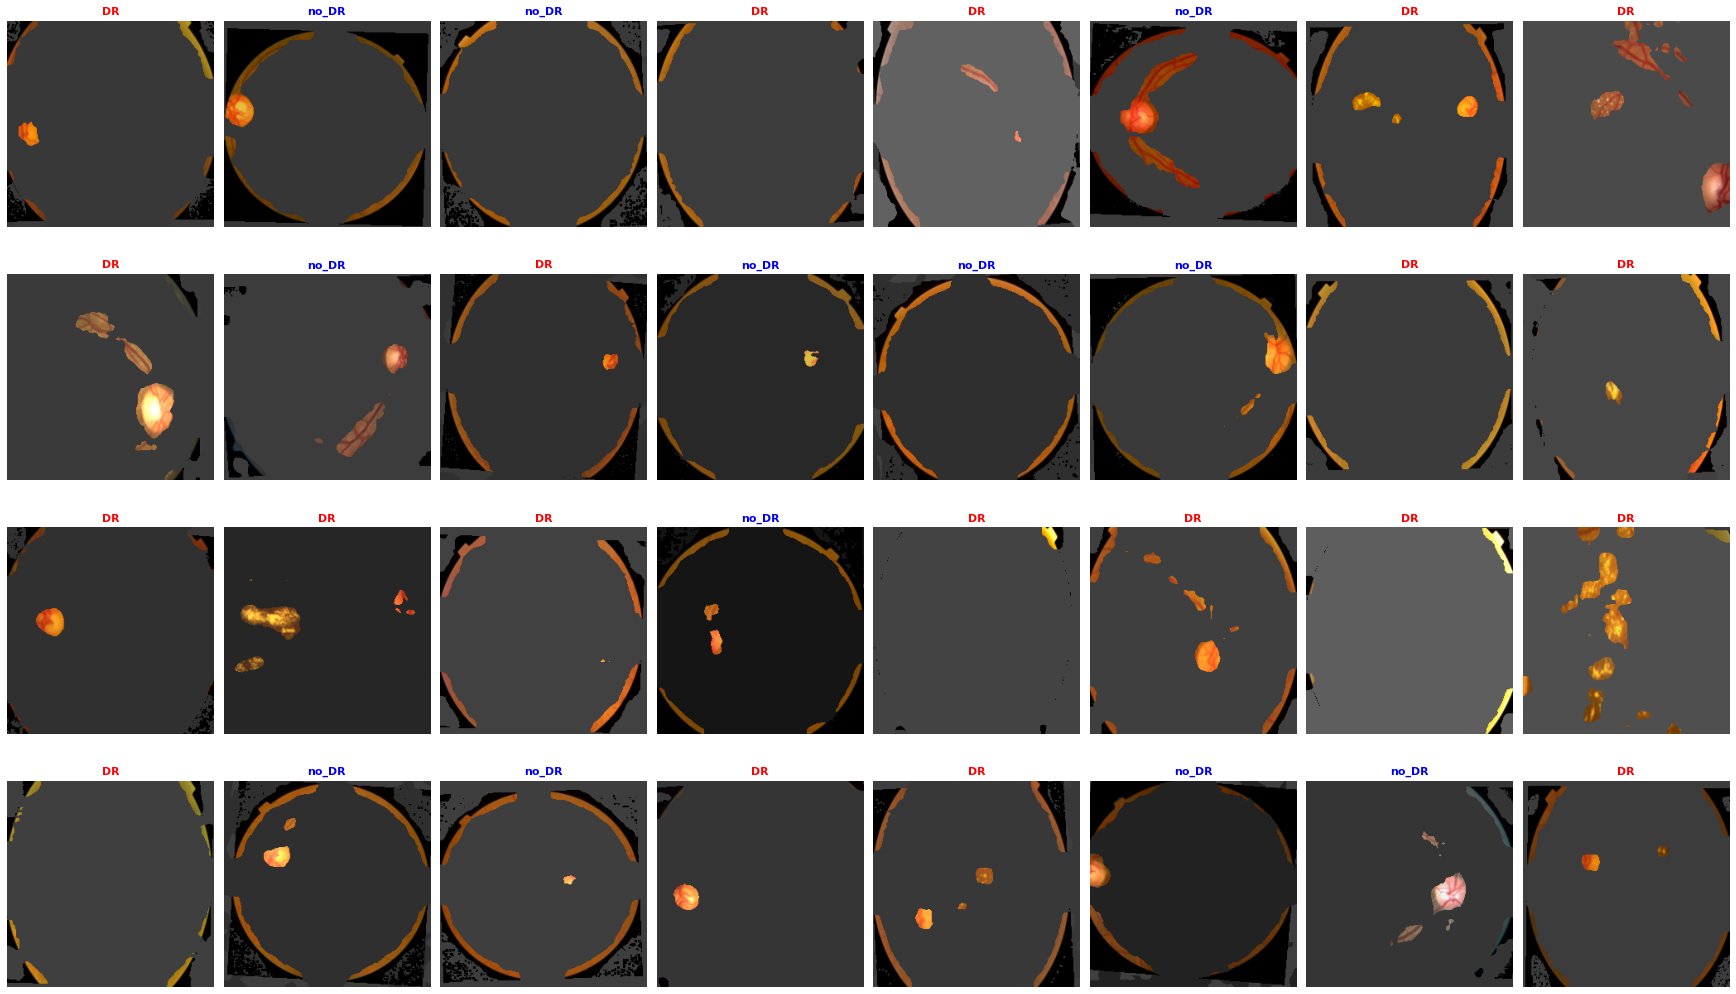


Validation Batch:


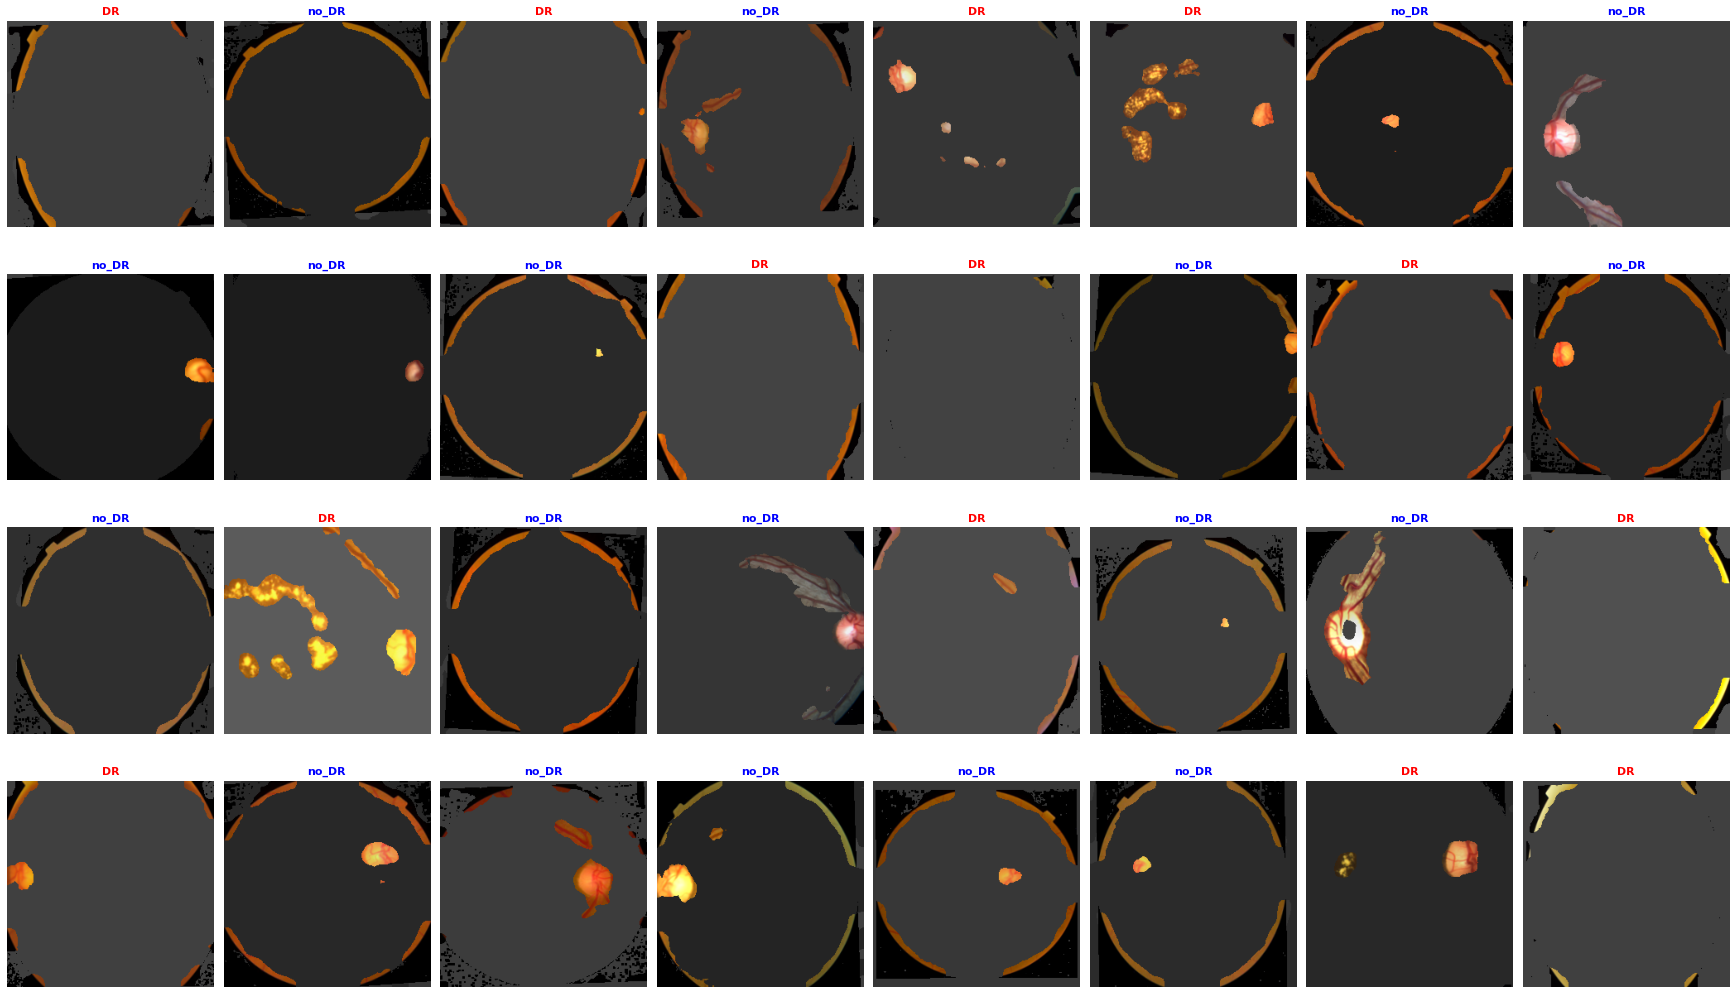

In [ ]:
print('Training Batch:')
visualize_augmentations(training_generator)

print('\nValidation Batch:')
visualize_augmentations(validation_generator)

In [ ]:
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet',
    # base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new layers to the end of the base model
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Add a final dense layer with a single neuron (logistic regression)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [ ]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE),
                  metrics=METRICS)

In [ ]:
def fit_model(model):
    # early_stopping_cb = EarlyStopping(monitor='val_accuracy',
    #                                   min_delta=MIN_DELTA,
    #                                   patience=PATIENCE,
    #                                   mode='max',
    #                                   restore_best_weights=True)
    
    # Make sure to change this model name
    # log_dir = logs + r'/EfficientNet-B4'
    # tensorboard_cb = TensorBoard(log_dir=log_dir,
    #                              histogram_freq=1)
    
    # callbacks = [early_stopping_cb, tensorboard_cb]
    
    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE))
                        # callbacks=callbacks)
    
    return history

In [ ]:
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4), constrained_layout=True)

    # I hand calculated F1-score since tfa's caused errors
    f1_scores = []
    # calculate f1-score from precision and recall
    for i in range(len(history.history['val_recall'])):
        if history.history['val_precision'][i] != 0 and history.history['val_recall'][i] != 0:
            f1_scores.append((2 * history.history['val_precision'][i] * history.history['val_recall'][i]) / (history.history['val_precision'][i] + history.history['val_recall'][i]))

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall', 'cohen_kappa']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])
        
        if metric is not 'loss':
            non_zeros = [num for num in history.history['val_' + metric] if num != 0]
            avg = "{:.4f}".format(np.mean(non_zeros))
            std = "{:.4f}".format(np.std(non_zeros))
            se = "{:.4f}".format(float(std) / (validation_generator.n) ** 0.5)
            print(metric + ': {} ± {}'.format(avg, se))
    
    # print f1-score
    f1_score = "{:.4f}".format(f1_scores[-1])
    avg = "{:.4f}".format(np.mean(f1_scores))
    std = "{:.4f}".format(np.std(f1_scores))
    se = "{:.4f}".format(float(std) / (validation_generator.n) ** 0.5)
    print('final f1-score: ' + f1_score)
    print('f1-score' + ': {} ± {}'.format(avg, se))

In [ ]:
model = create_model(print_summary=False)
compile_model(model)

In [ ]:
# fin = open(r'/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py', "rt")
# #read file contents to string
# data = fin.read()
# # print(data)
# #replace all occurrences of the required string
# # below makes it so that it's the original way the code was
# data = data.replace("np.multiply(x, self.rescale, out=x, casting='unsafe')", 'x *= self.rescale')
# #close the input file
# fin.close()
# #open the input file in write mode
# fin = open(r'/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py', "wt")
# #overrite the input file with the resulting data
# fin.write(data)
# #close the file
# fin.close()

In [ ]:
history = fit_model(model)

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.


Epoch 1/5
91/90 [==============================] - ETA: -3s - loss: 0.3802 - accuracy: 0.8655 - precision: 0.8616 - recall: 0.8708 - cohen_kappa: 0.7326

Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.


90/90 [==============================] - 1178s 13s/step - loss: 0.3802 - accuracy: 0.8655 - precision: 0.8616 - recall: 0.8708 - cohen_kappa: 0.7326 - val_loss: 0.2117 - val_accuracy: 0.9198 - val_precision: 0.9466 - val_recall: 0.9018 - val_cohen_kappa: 0.8392
Epoch 2/5
90/90 [==============================] - 1149s 13s/step - loss: 0.2465 - accuracy: 0.9107 - precision: 0.9155 - recall: 0.9007 - cohen_kappa: 0.8212 - val_loss: 0.2112 - val_accuracy: 0.9119 - val_precision: 0.9021 - val_recall: 0.9382 - val_cohen_kappa: 0.8223
Epoch 3/5
90/90 [==============================] - 1159s 13s/step - loss: 0.2366 - accuracy: 0.9159 - precision: 0.9212 - recall: 0.9056 - cohen_kappa: 0.8316 - val_loss: 0.1950 - val_accuracy: 0.9139 - val_precision: 0.9053 - val_recall: 0.9382 - val_cohen_kappa: 0.8263
Epoch 4/5
90/90 [==============================] - 1168s 13s/step - loss: 0.2219 - accuracy: 0.9241 - precision: 0.9298 - recall: 0.9141 - cohen_kappa: 0.8482 - val_loss: 0.1751 - val_accuracy: 

In [ ]:
# model.save(model_filepath)

In [ ]:
# load_in_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/ResNet-50V2'
# # load_in_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/EfficientNet-B2'
# model = load_model(load_in_model_filepath)

http://seaborn.pydata.org/tutorial/aesthetics.html

In [ ]:
sns.set_context("paper") # darker gray background on plots
# sns.set_style("whitegrid")
sns.set_theme()

accuracy: 0.9233 ± 0.0005
precision: 0.9243 ± 0.0008
recall: 0.9345 ± 0.0008
cohen_kappa: 0.8455 ± 0.0009
final f1-score: 0.9382
f1-score: 0.9291 ± 0.0004


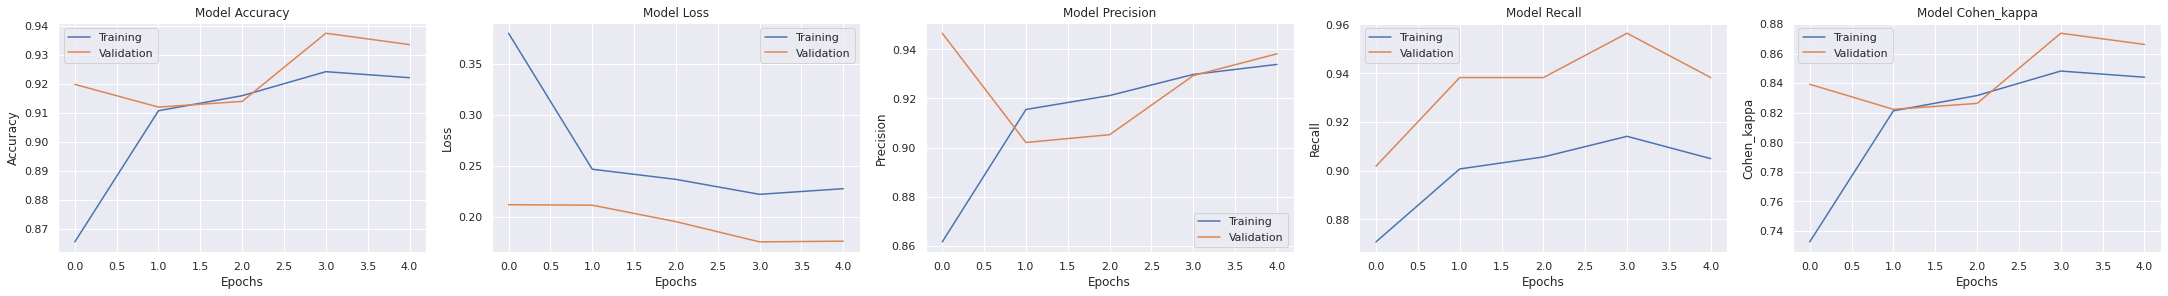

In [ ]:
evaluate_model(history)

In [ ]:
def grad_CAM(model, orig_img, intensity_factor, plot=True):
    with GradientTape() as tape:
        # ResNet-50V2
        last_conv_layer = model.get_layer('conv5_block3_3_conv')
        # DenseNet-201
        # last_conv_layer = model.get_layer('conv5_block32_2_conv')
        # mobile
        # last_conv_layer = model.get_layer('conv_pw_13')
        # effb2
        # last_conv_layer = model.get_layer('top_conv')
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(orig_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS))
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    np.seterr(divide='ignore', invalid='ignore')
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape(8, 8)
    # heatmap = heatmap.reshape(7, 7)

    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    colormap = cv2.applyColorMap(np.uint8(heatmap * 255), cv2.COLORMAP_JET)

    dimmed_heatmap = colormap * intensity_factor
    
    superimposed_img = ((dimmed_heatmap + orig_img) * 180).astype(np.uint8)

    if plot:
        plt.imshow(superimposed_img)
        plt.show()

    return superimposed_img, heatmap

In [ ]:
def guided_backprop(model, orig_img):
    # ResNet50-V2
    gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('conv5_block3_3_conv').output])
    # DenseNet-201
    # gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('conv5_block32_2_conv').output])
    # Mobile
    # gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('conv_pw_13').output])
    # effb2
    # gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('top_conv').output])

    with GradientTape() as tape:
        inputs = tf.cast(orig_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS), tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)[0]
        bp_grads = tape.gradient(outputs,inputs)[0]
    
    guided_bp = bp_grads

    guided_bp = np.dstack((guided_bp[:, :, 0],
                           guided_bp[:, :, 1],
                           guided_bp[:, :, 2]))
                
    enhanced_guided_bp = guided_bp / guided_bp.max()
    guided_bp -= np.min(guided_bp)
    norm_guided_bp = guided_bp / guided_bp.max()

    return guided_bp, enhanced_guided_bp, norm_guided_bp

In [ ]:
def guided_gradcam(norm_guided_bp, enhanced_guided_bp, guided_cam):
    guided_gc = np.dstack((norm_guided_bp[:, :, 0] * guided_cam,
                           norm_guided_bp[:, :, 1] * guided_cam,
                           norm_guided_bp[:, :, 2] * guided_cam))

    # enhanced_guided_gc = np.dstack((enhanced_guided_bp[:, :, 0] * guided_cam * 5,
    #                                 enhanced_guided_bp[:, :, 1] * guided_cam * 5,
    #                                 enhanced_guided_bp[:, :, 2] * guided_cam * 5))
    
    enhanced_guided_gc = np.dstack((enhanced_guided_bp[:, :, 0] * guided_cam * 10,
                                    enhanced_guided_bp[:, :, 1] * guided_cam,
                                    enhanced_guided_bp[:, :, 2] * guided_cam))
    
    return guided_gc, enhanced_guided_gc

In [ ]:
def run_diagnosis(model, img_array):
    # disclaimer = '*** DISCLAIMER ***\n' \
    #          'Do not rely on this prediction for self-diagnosis. ' \
    #          'Please check with your local authority services for ' \
    #          'seeking medical assistance.'

    # plt.text(0, 0.5,
    #         disclaimer,
    #         size=15,
    #         ha="center", va="center",
    #         bbox=dict(boxstyle="round",
    #                   ec=(1., 0., 0.),
    #                   fc=(1., 0.9, 0.9)))
    # plt.axis('off')

    resized_img = np.asarray(resize(img_array, TARGET_SIZE)).astype(np.uint8)
    np.seterr(divide='ignore', invalid='ignore')
    resized_img = resized_img / 255

    testing_img = resized_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    prediction = model.predict(testing_img)[0][0]
    # print('Prediction:', prediction)

    # Safe prediction for DR positive
    if prediction > THRESHOLD_VALUE:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(prediction * PERCENTAGE_FACTOR)[:5]
        
        font_settings.update({'color': 'red'})
        # plt.title(f'{network_prediction} ({network_percent_confidence}% match)', fontdict=font_settings)
        print(f'{network_prediction} ({network_percent_confidence}% match)')

    # Safe prediction for DR negative
    else:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str((1 - prediction) * PERCENTAGE_FACTOR)[:5]
        
        font_settings.update({'color': 'blue'})
        # plt.title(f'{network_prediction} ({network_percent_confidence}% match)', fontdict=font_settings)
        print(f'{network_prediction} ({network_percent_confidence}% match)')

    superimposed_img, guided_cam = grad_CAM(model, resized_img, 0.0015, plot=False)
    guided_bp, enhanced_guided_bp, norm_guided_bp = guided_backprop(model, resized_img)
    guided_gc, enhanced_guided_gc = guided_gradcam(norm_guided_bp, enhanced_guided_bp, guided_cam)    

    # fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    # axs[0, 0].imshow(superimposed_img)
    # axs[0, 1].imshow(np.clip(norm_guided_bp, a_min=0, a_max=1))
    # axs[1, 0].imshow(np.clip(guided_gc, a_min=0, a_max=1))
    # axs[1, 1].imshow(np.clip(enhanced_guided_gc, a_min=0, a_max=1))

    # axs[0, 0].grid(False)
    # axs[0, 1].grid(False)
    # axs[1, 0].grid(False)
    # axs[1, 1].grid(False)

    plt.axis('off')
    plt.grid(False)
    plt.imshow(resized_img)
    plt.show()

    plt.axis('off')
    plt.grid(False)
    plt.imshow(superimposed_img)
    plt.show()

    plt.axis('off')
    plt.grid(False)
    plt.imshow(np.clip(norm_guided_bp, a_min=0, a_max=1))
    plt.show()

    plt.axis('off')
    plt.grid(False)
    plt.imshow(np.clip(guided_gc, a_min=0, a_max=1))
    plt.show()
    
    plt.axis('off')
    plt.grid(False)
    plt.imshow(np.clip(enhanced_guided_gc, a_min=0, a_max=1))   
    plt.show()

In [ ]:
# #@title Run a Diagnostic Test {run: "auto", vertical-output: true}
# image_index = 24 #@param {type:"slider", min:1, max:32, step:1}

# testing_image = (image_batch[image_index - 1] * 255).astype(np.uint8)
# true_label = CLASSES[int(batch_labels[image_index - 1])]
# print('True Label', true_label)
# run_diagnosis(model, img_array=testing_image)

In [ ]:
# images, batch_lbls = next(img_generator)

In [ ]:
# background = image_batch[0:31]
# lbls = np.around(batch_labels[0:31].copy()).astype(int)

In [ ]:
# exemplary_backgrounds = []
# exemplary_lbls = []

In [ ]:
# exemplary_backgrounds.append(background[-8])
# exemplary_lbls.append(lbls[-8])

In [ ]:
# exemplary_pos_backgrounds = []
# exemplary_neg_backgrounds = []

In [ ]:
# exemplary_neg_backgrounds = exemplary_neg_backgrounds[2:]
# exemp_pos_copy = exemplary_pos_backgrounds[4:6]

In [ ]:
# for i, img in enumerate(exemplary_backgrounds):
#   if exemplary_lbls[i] == 0:
#     exemplary_neg_backgrounds.append(img)
#   # else:
#   #   exemplary_pos_backgrounds.append(img)

In [ ]:
# exemp_negs_copy = exemplary_neg_backgrounds.copy()

In [ ]:
# exemp_negs_copy.pop(3)

In [ ]:
# print(len(exemplary_neg_backgrounds))

In [ ]:
# for i, img in enumerate(exemp_negs_copy):
#   plt.imshow(img)
#   plt.show()
#   # print(exemplary_lbls[i])

In [ ]:
# # THE BELOW CODE DID NOT WORK for EB2, only ResNet-50V2

# # explain predictions of the model on "n_explain" images
# # background = image_batch[0:1]
# # lbls = batch_labels[0:1]
# # n_explain = 2

# shap.explainers._deep.deep_tf.op_handlers['FusedBatchNormV3'] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers['AddV2'] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers['DepthwiseConv2dNative'] = shap.explainers._deep.deep_tf.passthrough
# # e = shap.DeepExplainer(model, background)
# # shap_values = e.shap_values(background)

# e_2 = shap.DeepExplainer(model, np.asarray(exemp_negs_copy))
# shap_values_2 = e_2.shap_values(np.asarray(exemp_negs_copy))

# # plot the feature attributions
# # shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)
# # shap.image_plot(shap_values, -background[:n_explain])

In [ ]:
# # print(np.asarray(exemplary_pos_backgrounds)[0, :, :, :].shape)
# print(np.asarray(exemplary_pos_backgrounds)[0].reshape(1, 250, 250, 3).shape)

In [ ]:
# # shap.image_plot(shap_values, -background, labels=[lbls], hspace=0.1)
# shap.image_plot(shap_values_2, np.asarray(exemp_negs_copy), aspect=0.2, hspace=0.05)
# shap.image_plot(np.asarray(shap_values_2)[:, 0, :, :, :], np.asarray(exemp_negs_copy)[0].reshape(1, 250, 250, 3), aspect=0.2, hspace=0.05)
# # plt.grid(True)
# # plt.show()

In [ ]:
# print(len(model.layers))

In [ ]:
# # Extracts the outputs of the top 12 layers
# start_layer = 22
# end_layer = 24
# layer_outputs = [layer.output for layer in model.layers[start_layer:end_layer]]
# layer_names = []
# for layer in model.layers[start_layer:end_layer]:
#     layer_names.append(layer.name)
# # layer_outputs = [layer.output for layer in model.layers[150:152]]
# # Creates a model that will return these outputs, given the model input
# activation_model = Model(inputs=model.input, outputs=layer_outputs)

# resized_img = np.asarray(resize(testing_image, TARGET_SIZE)).astype(np.uint8)
# np.seterr(divide='ignore', invalid='ignore')
# resized_img = resized_img / 255

# testing_img = resized_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)
# # Returns a list of five Numpy arrays: one array per layer activation
# activations = activation_model.predict(testing_img)
# first_layer_activation = activations[0]
# plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

# # print(layer_names[0])
# # plt.matshow(first_layer_activation[:, :, 4], cmap='viridis')
# # plt.grid(False)
# # plt.axis('off')
# # plt.show()
# # plt.imshow(first_layer_activation[:, :, 4], cmap='viridis')
# # plt.grid(False)
# # plt.show()

In [ ]:
# layer_names = []
# for layer in model.layers[start_layer:end_layer]:
#     layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

# images_per_row = 16

# for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
#     n_features = layer_activation.shape[-1] # Number of features in the feature map
#     size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
#     n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
#     display_grid = np.zeros((size * n_cols, images_per_row * size))
#     for col in range(n_cols): # Tiles each filter into a big horizontal grid
#         for row in range(images_per_row):
#             channel_image = layer_activation[0, :, :, col * images_per_row + row]
#             channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size, # Displays the grid
#                          row * size : (row + 1) * size] = channel_image
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis') # cmap='gray', 'viridis', or just leave out param also yield pretty plots

In [ ]:
# def plot_confusion_matrix(data_generator, predictions):
#     cm = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
#     cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    
#     cm_display.plot(include_values=True,
#                     cmap='Blues',
#                     xticks_rotation=45,
#                     values_format='.5g')
    
#     plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
#                                               'color' : 'black',
#                                               'weight': 'heavy',
#                                               'size'  :  12})
#     plt.tick_params(axis=u'both', which=u'both',length=0)
#     plt.grid(b=None)

#     plt.show()

In [ ]:
# # not much a difference from ^, but might just look better and maybe easier to work with
# # note that it has a weird font and style when plotting graphs, RUN THIS LAST..
# def plot_heatmap_confusion_matrix(data_generator, predictions):
#     cf = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
    
#     df_cm = pd.DataFrame(cf, range(len(CLASSES)), range(len(CLASSES)))
#     plt.figure(figsize=(6, 4))
#     sns.set(font_scale=1.0)
#     sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=CLASSES, yticklabels=CLASSES, fmt='g')
#     # sns.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size": 16}, xticklabels=CLASSES, yticklabels=CLASSES, fmt='g')

#     plt.xlabel('Predicted Labels', labelpad=20)
#     plt.ylabel('Ground Truth Labels', labelpad=20)
#     plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
#                                               'color' : 'black',
#                                               'weight': 'heavy',
#                                               'size'  :  12})
#     plt.show()

In [ ]:
# def plot_precision_recall(data_generator, predictions, ax):
#     precision, recall, thresholds = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions)
#     average_precision = average_precision_score(y_true=data_generator.labels, y_score=predictions)
#     pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name=None)
    
#     pr_display.plot(ax=ax, name='Proposed Model')
    
#     ax.set_title('Precision Recall Curve', fontdict = {'family': 'DejaVu Sans',
#                                                        'color' : 'black',
#                                                        'weight': 'heavy',
#                                                        'size'  :  12})

In [ ]:
# def plot_roc_curve(data_generator, predictions, ax):
#     ns_predictions = [0 for i in range(data_generator.n)]

#     ns_auc = roc_auc_score(y_true=data_generator.labels, y_score=ns_predictions)
#     auc = roc_auc_score(y_true=data_generator.labels, y_score=predictions)

#     ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_true=validation_generator2.labels, y_score=ns_predictions)
#     fpr, tpr, thresholds = roc_curve(y_true=validation_generator2.labels, y_score=predictions)    

#     ax.plot(fpr, tpr, marker='.', label='Proposed Model (AUC = %0.3f)' % auc)
#     ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = %0.3f)' % ns_auc)

#     ax.set_title('ROC Curve', fontdict = {'family': 'DejaVu Sans',
#                                          'color' : 'black',
#                                          'weight': 'heavy',
#                                          'size'  :  12})
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.legend()

In [ ]:
# def print_classification_report(data_generator, predictions):
#     cr = classification_report(y_true=data_generator.labels, y_pred=predictions)
#     print(cr)

In [ ]:
# # we need to load in an unshuffled val gen for evaluation purposes
# validation_generator2 = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
#                                                     subset = "validation",
#                                                     x_col = "id_code", y_col = "diagnosis",
#                                                     color_mode=COLOR_MODE,
#                                                     target_size=TARGET_SIZE,
#                                                     class_mode='binary',
#                                                     batch_size=BATCH_SIZE,
#                                                     interpolation="bicubic",
#                                                     shuffle=False, # has to be false for evaluations to work
#                                                     validate_filenames=True)

In [ ]:
# predictions = model.predict(validation_generator2,
#                             verbose=1)
# rounded_predictions = np.around(predictions.copy()).astype(int)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# plot_roc_curve(validation_generator2, predictions, ax1)
# plot_precision_recall(validation_generator2, predictions, ax2)

In [ ]:
# plot_confusion_matrix(validation_generator2, rounded_predictions)

In [ ]:
# plot_heatmap_confusion_matrix(validation_generator2, rounded_predictions)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html - INCLUDE LABELS PARAM TO GET MICRO_AVG
# print_classification_report(validation_generator2, rounded_predictions)

In [ ]:
# # Don't need since we already calculated this when fitting the model
# ck_score = cohen_kappa_score(rounded_predictions, validation_generator.labels, weights='quadratic')
# print("Cohen Kappa score: %.3f" % ck_score)

---

Everything below is from cross validation, disregard

In [ ]:
# for train_index, val_index in skf.split(np.zeros(1187), Y):
 
#   training_data = train_data.iloc[train_index]
#   validation_data = train_data.iloc[val_index]
  
  
  # training_generator = data_gen.flow_from_dataframe(training_data, directory = dataset_dir,
  #                                                   x_col = "Image Name", y_col = "Retinopathy Grade",
  #                                                   color_mode=COLOR_MODE,
  #                                                   target_size=TARGET_SIZE,
  #                                                   class_mode='binary',
  #                                                   batch_size=BATCH_SIZE,
  #                                                   interpolation="bicubic",
  #                                                   shuffle=True,
  #                                                   validate_filenames=True)

  # validation_generator = data_gen.flow_from_dataframe(validation_data, directory = dataset_dir,
  #                                                   x_col = "Image Name", y_col = "Retinopathy Grade",
  #                                                   color_mode=COLOR_MODE,
  #                                                   target_size=TARGET_SIZE,
  #                                                   class_mode='binary',
  #                                                   batch_size=BATCH_SIZE,
  #                                                   interpolation="bicubic",
  #                                                   shuffle=True,
  #                                                   validate_filenames=True)
  
#   # print(training_generator)
	
 
#   model = create_model(print_summary=True)
#   compile_model(model)
	
# 	# # CREATE CALLBACKS
#   # checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + get_model_name(fold_var), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#   # callbacks_list = [checkpoint]
# 	# # There can be other callbacks, but just showing one because it involves the model name
# 	# # This saves the best model
# 	# # FIT THE MODEL
  
#   history = fit_model(model)
 
# 	# #PLOT HISTORY
# 	# #		:
# 	# #		:
	
# 	# # LOAD BEST MODEL to evaluate the performance of the model
#   # model.load_weights(save_dir + '/model_' + str(fold_var) + ".h5")
#   # results = model.evaluate(valid_data_generator)
#   # results = dict(zip(model.metrics_names,results))
  
#   # VALIDATION_ACCURACY.append(results['accuracy'])
#   # VALIDATION_LOSS.append(results['loss'])
#   # tf.keras.backend.clear_session()


#   fold_var += 1

In [ ]:
# def get_model_name(k):
#     return 'model_'+str(k)+'.h5'

In [ ]:
# X_train = []

# for img in (train_data['Image Name']):
#     loaded_img = load_img(os.path.join(dataset_dir, img))
#     img_arr = img_to_array(loaded_img)
#     X_train.append(img_arr)
  
# y_train = train_data.drop('Retinopathy Grade', axis=1, inplace=False)

# X_train = np.array(X_train)
# y_train = np.array(y_train.values)

# print(X_train)
# print(y_train)

# sm = SMOTE()
# training_data = sm.fit_resample()

# from PIL import Image
# import glob

# X_train = []
# for img in glob.glob('/content/drive/MyDrive/cropped_messidor_dataset/*.tif'): #assuming gif
#     im=Image.open(img)
#     X_train.append(im)

# y_train = training_data.drop('Retinopathy Grade', axis=1, inplace=False)

# y_train = np.array(y_train.values)
# X_train = np.array(X_train)